In [1]:
# | tags: [parameters]
subject = "106"

In [2]:
#| tags: [parameters]
# Injected Parameters
subject = 152


In [3]:
from datetime import datetime


def print_date_time():
    now = datetime.now()
    # Convert the date and time to a string
    now_str = now.strftime("%Y-%m-%d %H:%M:%S")

    # Print the date and time
    print(now_str)


print_date_time()

2024-03-19 06:47:38


In [4]:
import mne
import autoreject
import toml

from pathlib import Path
from autoreject import AutoReject
import numpy as np
import matplotlib.pyplot as plt

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")


config = toml.load("../../.env.toml")
project_path = config["project"]["path"]

epochs_path = f"{
    project_path}/data/preproc/sub-{subject}/epochs/"
preproc_path = f"{
    project_path}/data/preproc/sub-{subject}/raw/"
figure_path = f"{project_path}/analysis/sub-{subject}/figures"

Path(epochs_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)


def create_epochs(raw):
    length = 5
    events = mne.make_fixed_length_events(
        raw=raw,
        start=0,
        stop=None,
        duration=length,
        overlap=0,
        first_samp=False,
    )

    # Create  Epochs object
    epochs = mne.Epochs(
        raw=raw,
        events=events,
        tmin=0,
        tmax=length,
        detrend=1,  # from 0 to 1
        baseline=None,
        preload=True,
    )
    return epochs


def plot_epochs(epochs, stage="epochs", n_epochs=10, n_channels=10, fmax=100.0):
    # plot the data
    epochs_plot = epochs.copy().average().detrend().plot_joint()
    epochs_plot.savefig(
        f"{figure_path}/sub-{subject}_{stage}.png", dpi=300, bbox_inches="tight"
    )
    mne.viz.plot_epochs(
        epochs=epochs,
        picks="eeg",
        show=False,
        n_epochs=n_epochs,
        n_channels=n_channels,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
    epochs_plot_psd = epochs.compute_psd(
        method="welch", picks="eeg", fmax=100.0, exclude="bads"
    ).plot(average=True, picks="eeg", exclude="bads", show=False)
    epochs_plot_psd.savefig(
        f"{figure_path}/sub-{subject}_{stage}_psd.png", dpi=300, bbox_inches="tight"
    )


def visualise_bads(reject_log):
    """Visualise the bad epochs and channels."""
    bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)
    plt.imshow(bads, cmap="viridis")
    plt.colorbar(orientation="horizontal", pad=0.1)
    plt.show()

    print(
        f"Currently removed number of epochs {
            np.sum(reject_log.bad_epochs)}"
    )
    # print(bads)
    # print(bads.shape)
    good_epochs_percentage = (1 - bads.mean(axis=1)) * 100

    # print("Percentage of bad epochs in each epoch:")
    # display(good_epochs_percentage)

    print("Percentage of good epochs in each  candidate for removal epoch:")
    for i in range(0, len(good_epochs_percentage)):
        if good_epochs_percentage[i] < 75:
            print(f"Epoch {i}: {good_epochs_percentage[i]:.2f}%")
            # print(f"Epoch {i}: {good_epochs_percentage[i]:.2f}%")

Using matplotlib as 2D backend.


# Get bad channels


Opening raw data file /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-152/raw//sub-152_filtered_zap_eeg.fif...


    Range : 0 ... 147499 =      0.000 ...   294.998 secs


Ready.


Reading 0 ... 147499  =      0.000 ...   294.998 secs...


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"243 EEG, 1 ECG"
Bad channels,"VREF, E9, E52, E68, E146, E147, E186, E187, E188, E199, E209, E216, E217, E229"
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


Not setting metadata


59 matching events found


No baseline correction applied


0 projection items activated


Using data from preloaded Raw for 59 events and 1251 original time points ...


1 bad epochs dropped


No projector specified for this dataset. Please consider the method self.add_proj.


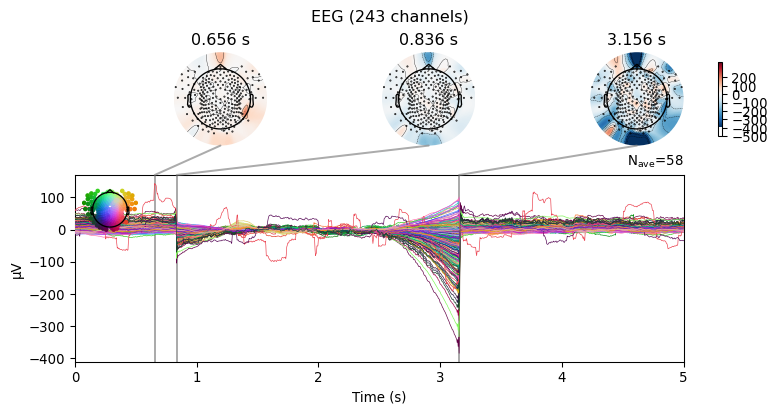

Effective window size : 5.004 (s)


Averaging across epochs...


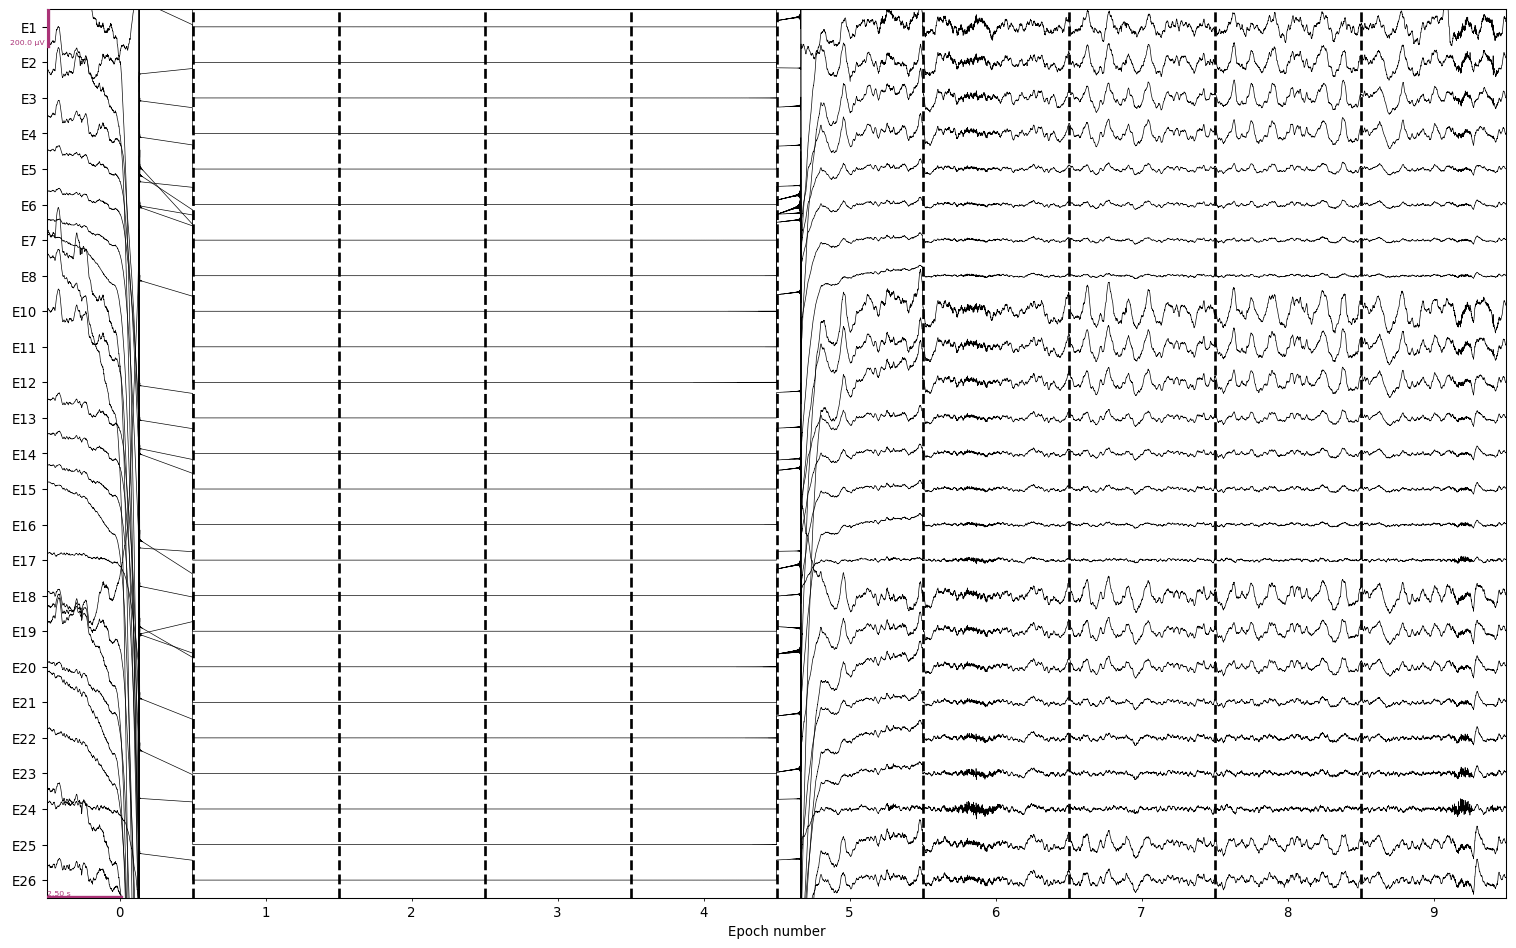

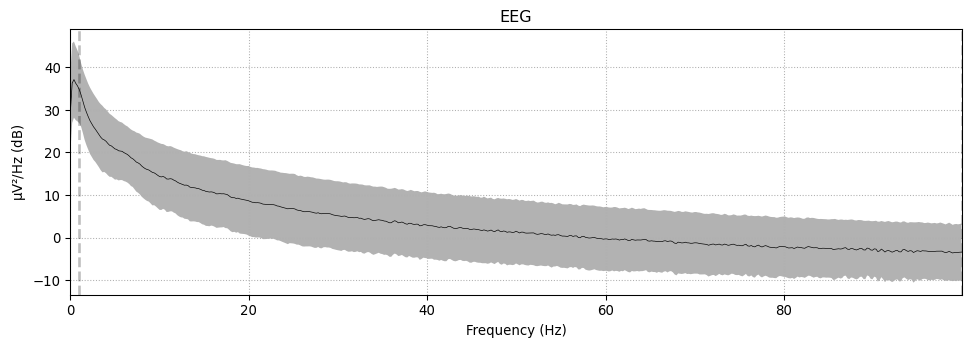

In [5]:
clean_raw = mne.io.read_raw_fif(
    f"{preproc_path}/sub-{subject}_filtered_zap_eeg.fif", preload=True
)
display(clean_raw.info)
clean_raw_downsampled = clean_raw.copy().resample(250, npad="auto")
epochs = create_epochs(clean_raw_downsampled)
plot_epochs(epochs, stage="epochs", n_epochs=10, n_channels=25)

Dropped 54 epochs: 0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57


No projector specified for this dataset. Please consider the method self.add_proj.


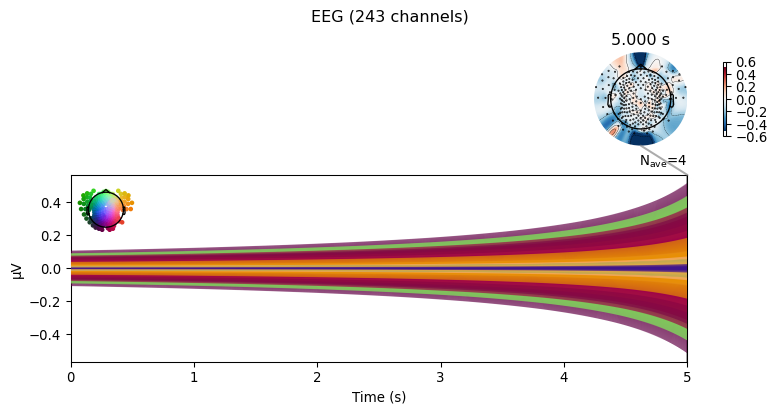

Effective window size : 5.004 (s)


Averaging across epochs...


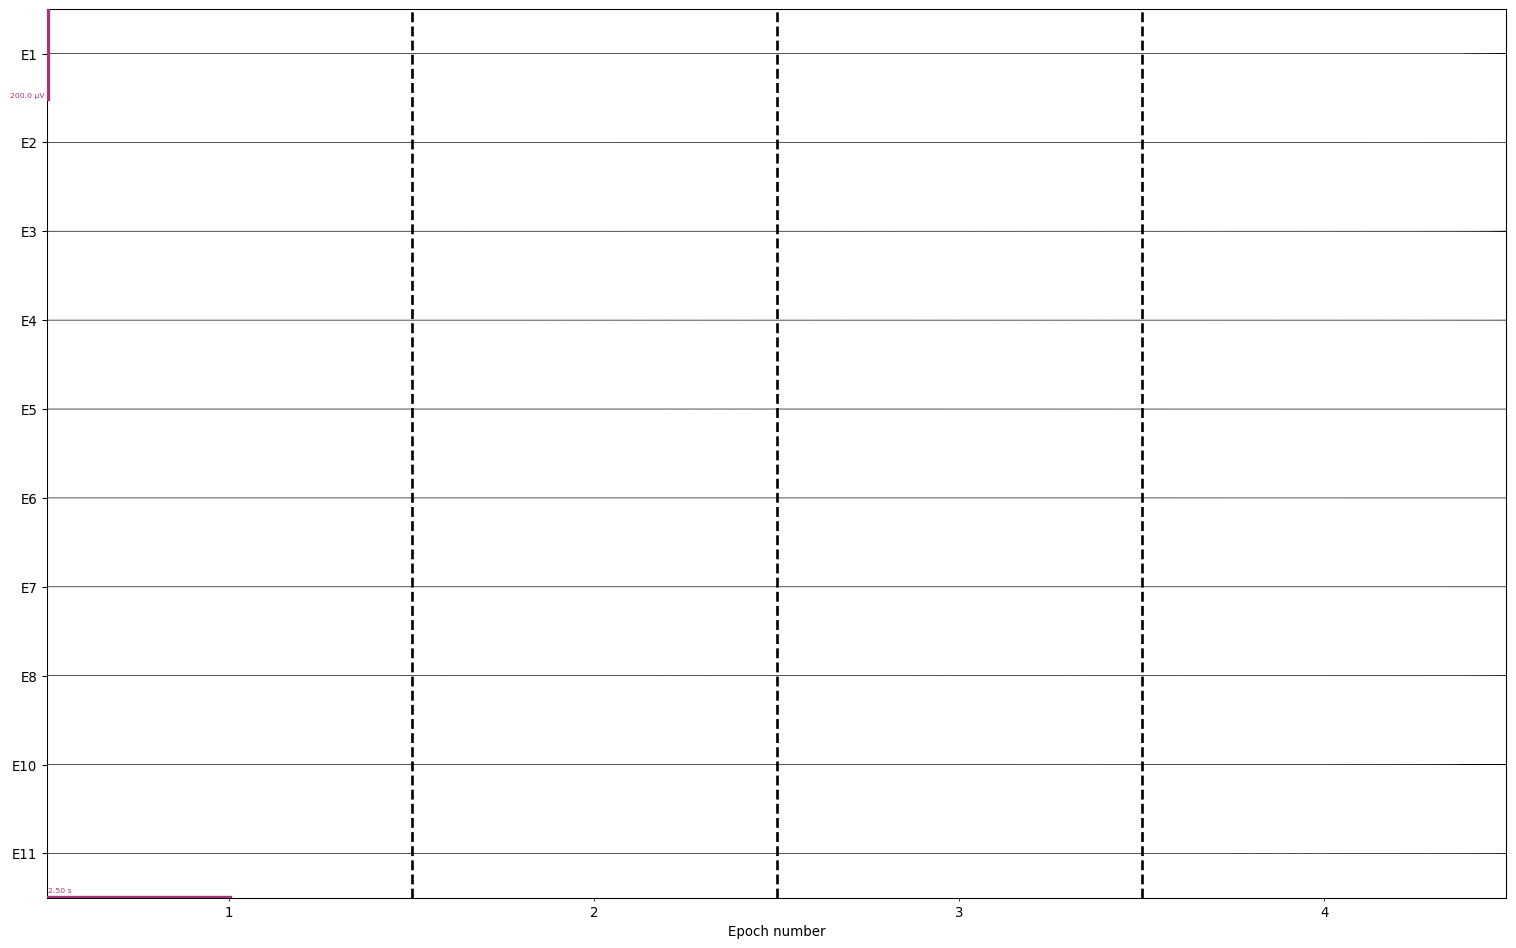

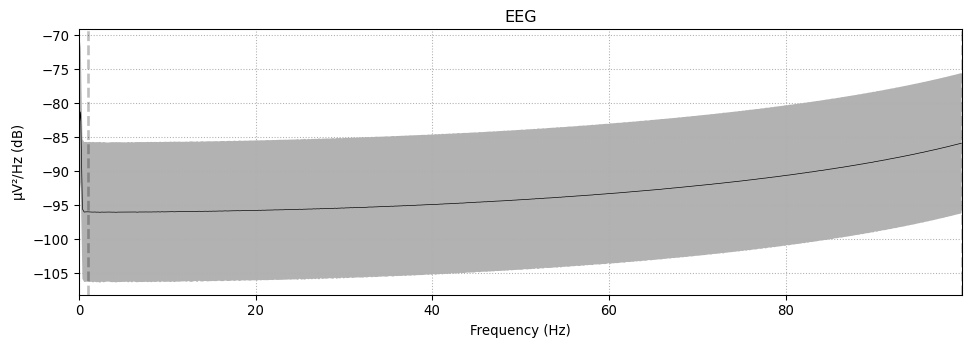

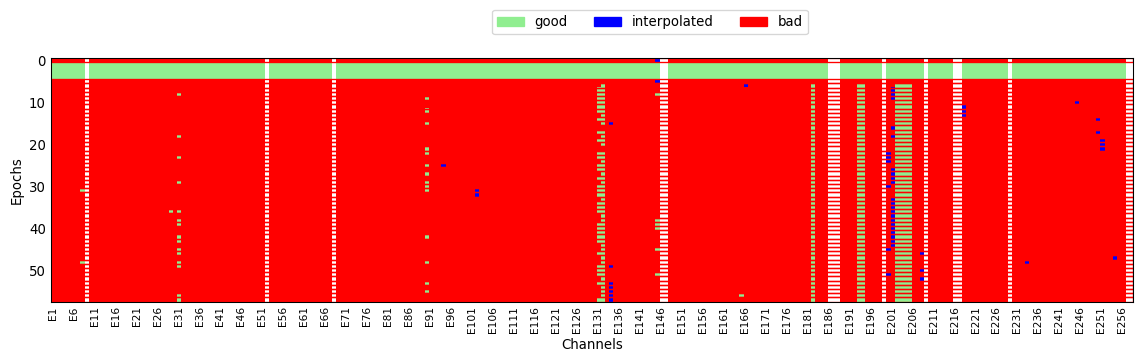

In [6]:
auto_reject_pre_ica = AutoReject(
    n_interpolate=[1, 2, 4, 8, 32, 64, 128],
    n_jobs=-1,
    random_state=100,
    thresh_method="random_search",
    verbose=False,
    # n_interpolate=np.array([0]),
    # consensus=0.8,
).fit(epochs[:20])
epochs_ar, reject_log = auto_reject_pre_ica.transform(epochs, return_log=True)

plot_epochs(
    epochs[~reject_log.bad_epochs],
    stage="autoreject_good_epochs",
    n_epochs=10,
    n_channels=10,
)
reject_plot = reject_log.plot("vertical")
# print(reject_log.bad_epochs)

In [7]:
epochs[~reject_log.bad_epochs].save(
    f"{epochs_path}/sub-{subject}_drop_bad-epo.fif", overwrite=True
)

In [8]:
print(f"{subject} -  removed {sum(reject_log.bad_epochs)} epochs")
print_date_time()

152 -  removed 54 epochs
2024-03-19 06:48:17
